# Analyzing-House-Sales-in-King-County-Washington
**Authors:** Connor McClain & Cooper Thompson

# Overview

Data was gathered about house sales in King County, Washington to find a model to predict if a house is worth buying at its listed price and to find what are the best things to increase the value of the house after buying it. The House price predictor was made through making a linear regression model. The two main factors we found that could actually be changed to raise the price of a house were the Sqft Living, and the condition of the house.


# Introduction to the Problem

Vladamir Geonoffe Housing Co. has approached us with the task to give him a house price predictor and two factors to focus on improving about the house after buying to increase the price. He also made it clear that he didn't want to buy any house over 1,000,000 dollars or more than 6 bedrooms. With that said we do understand from a business side that nothing we say is a gaurentee that profit will be made. There is always inherent risk in the house market, but we definitely have found trends that give higher chance to be successful.

# Data Understanding

As mentioned above in overview we gathered data from King County, Washinton's website. The data is not as complete as it could be since it data from 2014 and 2015. With more time, we would like to build a newer model from more modern data.

[Source](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)


# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings

### Cleaning Warnings

In [2]:
warnings.filterwarnings("ignore")

## Importing Data

In [3]:
df = pd.read_csv("../dsc-phase-2-project-v2-3/data/kc_house_data.csv", parse_dates=[1])

# Data preparation

## Observation of base DataFrame

We started by exploring the data then the nulls. We looked into the nulls to see if they were repersenting any value, or if they were miss entered information. We also checked to see if it was okay to just drop all the data that had nulls. Dropping all the nulls would leave us with around 15,500  of our original 21,500 data. We deemed this still enough data to make a model out of, so we dropped all the nulls. Also due to our client specifications of what type of houses he wants to buy, we dropped any houses that were priced at \$1,000,000 or higher or had more than 6 bedrooms. We also had to get rid of the data that had '?' just randomly in a column. 

In [4]:
df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062


In [5]:
df.info()
# we can see there are some nulls, since the nulls are 
#of a small enough proportion of our data set
# and our dataframe is big enough we shall drop them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

### Observing columns with nulls and objects

In [6]:
df["waterfront"].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [7]:
df["view"].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [8]:
df["yr_renovated"].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [9]:
df["condition"].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [10]:
df["grade"].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [11]:
df["sqft_basement"].value_counts()
# going to have to remove the ?

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
415.0         1
1284.0        1
225.0         1
3000.0        1
2240.0        1
Name: sqft_basement, Length: 304, dtype: int64

### Maps

We set the maps centered on 0 were possible

In [12]:
# map of condition
map_cond = {
    "Poor" : -2,
    "Fair" : -1,
    "Average" : 0,
    "Good" : 1,
    "Very Good" : 2   
}

In [13]:
# map of grade
map_grade = {
    "3 Poor" : -4,
    "4 Low" : -3,
    "5 Fair" : -2,
    "6 Low Average" : -1,
    "7 Average" : 0,
    "8 Good" : 1,
    "9 Better" : 2,
    "10 Very Good" : 3,
    "11 Excellent" : 4,
    "12 Luxury" : 5,
    "13 Mansion" : 6
}

In [14]:
# map of view
map_view = {
    "NONE" : -2,
    "FAIR" : -1,
    "AVERAGE" : 0,
    "GOOD" : 1,
    "EXCELLENT" : 2
}

In [15]:
# map of waterfront
# we chose 0 for no since there would be 0 waterfronts similiarly for yes
map_water = {
    "NO" : 0,
    "YES" : 1
}

Now we apply the maps

In [16]:
df["condition"] = df["condition"].map(map_cond)
df["grade"] = df["grade"].map(map_grade)
df["view"] = df["view"].map(map_view)
df["waterfront"] = df["waterfront"].map(map_water)

Since Valdemar Geonoffe only wants to flip houses that cost $1000000 dollars or less we drop the appropriate rows.

Also to make our data more reliable we dropp all rows with more than 6 bedrooms.

All this means we do not recommend this model be used on houses with 7 or more bedrooms or with a price of over $1000000.

## Dropping nulls and other similar null types

In [17]:
df = df.loc[(df["price"] <= 1000000) & (df["bedrooms"] <= 6)]

In [18]:
df = df.dropna()
df = df.loc[df["sqft_basement"] != "?"]
df["sqft_basement"] = df["sqft_basement"].astype(float)
# we drop nulls and ? as previously described

In [19]:
df.describe()
#we can now run the .describe since all are collumns are numbers

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.435900e+04,14359.000000,14359.000000,14359.000000,14359.000000,1.435900e+04,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000,14359.000000
mean,4.621273e+09,468052.668779,3.317014,2.041403,1956.623790,1.476112e+04,1.470959,0.002855,-1.842329,0.406714,0.511108,1694.979386,261.644404,1970.889686,71.155025,98078.040114,47.554915,-122.212653,1911.798036,12481.189428
std,2.875686e+09,196562.825376,0.856583,0.695269,750.827983,4.099013e+04,0.534920,0.053361,0.614461,0.646806,1.012321,709.352851,402.478549,29.024416,370.065282,53.263435,0.141886,0.142367,598.761135,26801.527710
min,1.000102e+06,82000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,-2.000000,-2.000000,-4.000000,370.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.155250e+09,313500.000000,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,-2.000000,0.000000,0.000000,1170.000000,0.000000,1952.000000,0.000000,98033.000000,47.456200,-122.330000,1470.000000,5060.000000
50%,3.955900e+09,435000.000000,3.000000,2.000000,1850.000000,7.500000e+03,1.000000,0.000000,-2.000000,0.000000,0.000000,1510.000000,0.000000,1975.000000,0.000000,98065.000000,47.565200,-122.230000,1800.000000,7548.000000
75%,7.347600e+09,590000.000000,4.000000,2.500000,2410.000000,1.025200e+04,2.000000,0.000000,-2.000000,1.000000,1.000000,2080.000000,500.000000,1996.000000,0.000000,98118.000000,47.679600,-122.121000,2260.000000,9875.500000
max,9.895000e+09,1000000.000000,6.000000,6.000000,7120.000000,1.651359e+06,3.500000,1.000000,2.000000,2.000000,5.000000,5710.000000,2720.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,4950.000000,871200.000000


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14359 entries, 1 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             14359 non-null  int64         
 1   date           14359 non-null  datetime64[ns]
 2   price          14359 non-null  float64       
 3   bedrooms       14359 non-null  int64         
 4   bathrooms      14359 non-null  float64       
 5   sqft_living    14359 non-null  int64         
 6   sqft_lot       14359 non-null  int64         
 7   floors         14359 non-null  float64       
 8   waterfront     14359 non-null  float64       
 9   view           14359 non-null  float64       
 10  condition      14359 non-null  int64         
 11  grade          14359 non-null  int64         
 12  sqft_above     14359 non-null  int64         
 13  sqft_basement  14359 non-null  float64       
 14  yr_built       14359 non-null  int64         
 15  yr_renovated   1435

we drop date since we do not use the date

In [21]:
df = df.drop(columns=["date"])

# Observing data correlation

<AxesSubplot:>

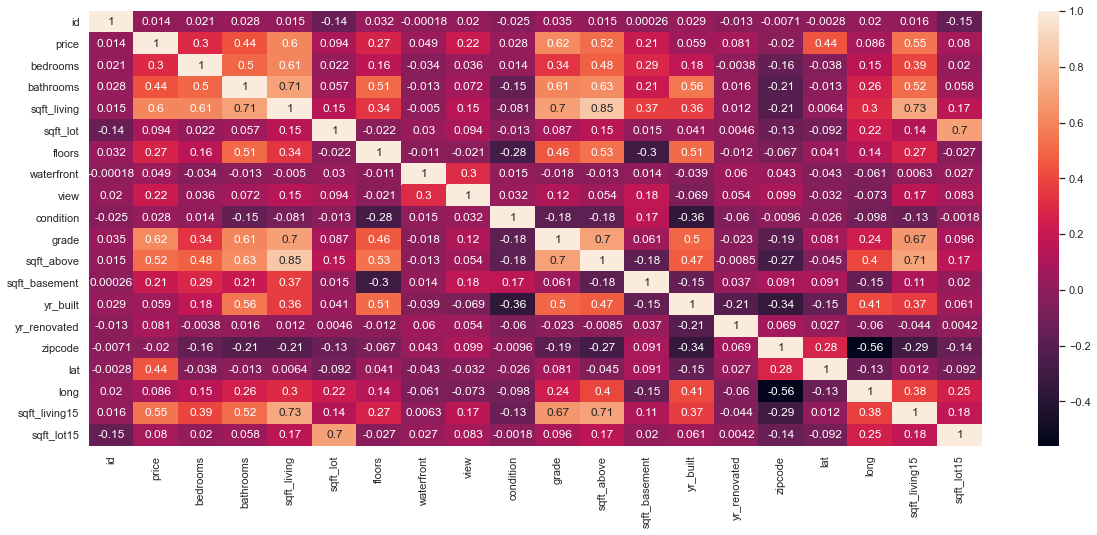

In [22]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.heatmap(df.corr(), annot=True)

# Modeling

### First Model

Since sqft and grade are so similiar we chose sqft living since we thought it would better represent the price. We started out our modeling by doing a baseline linear regression model using Sqft Living of the house to see how that relates to the price of the house. The results were a r-squared of 0.366 and the p_value of the f statistic was 0.

In [24]:
X = df["sqft_living"]
y = df["price"]

sqft_price = sm.OLS(y, sm.add_constant(X)).fit()
simple_model_summary = sqft_price.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     8282.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:00:16   Log-Likelihood:            -1.9212e+05
No. Observations:               14359   AIC:                         3.842e+05
Df Residuals:                   14357   BIC:                         3.843e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.582e+05   3646.387     43.393      0.000    1.51e+05    1.65e+05
sqft_living   158.3463      1.740     91.008      0.000     154.936     161.757
==============================================================================
Omnibus:                      484.779   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              534.420
Skew:                           0.471   Prob(JB):                    8.96e-117
Kurtosis:                       2.929   Cond. No.                     5.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

First Model Prediction Error Graph

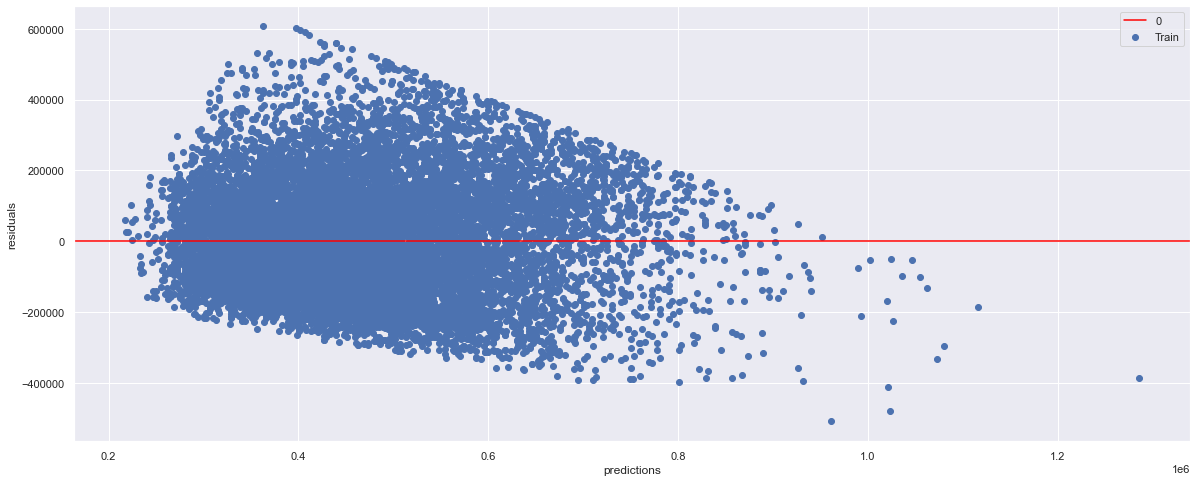

In [25]:
preds = sqft_price.predict(sm.add_constant(X))    


plt.scatter(preds, y-preds, label='Train')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

We can see the residuals are fairly spread out, there seems to be a line were the residuals do not cross.

### Second Model

The next interation of modeling was making a linear regression kitchen sink model. The results were a r-squared of 0.691 and p-value of f statistic of 0.

In [26]:
X1 = df.drop(columns=["price"])
y1 = df["price"]

all_price = sm.OLS(y1, sm.add_constant(X1)).fit()
simple_model_summary = all_price.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     1783.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:00:24   Log-Likelihood:            -1.8696e+05
No. Observations:               14359   AIC:                         3.739e+05
Df Residuals:                   14340   BIC:                         3.741e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -5.59e+06   1.96e+06     -2.852      0.004   -9.43e+06   -1.75e+06
id             3.356e-07   3.22e-07      1.042      0.298   -2.96e-07    9.67e-07
bedrooms      -9913.4803   1398.258     -7.090      0.000   -1.27e+04   -7172.713
bathrooms      2.246e+04   2273.281      9.880      0.000     1.8e+04    2.69e+04
sqft_living      45.8968      1.703     26.954      0.000      42.559      49.235
sqft_lot          0.2367      0.031      7.540      0.000       0.175       0.298
floors         3.175e+04   2465.017     12.879      0.000    2.69e+04    3.66e+04
waterfront     1.225e+05    1.8e+04      6.796      0.000    8.72e+04    1.58e+05
view           2.913e+04   1644.556     17.713      0.000    2.59e+04    3.24e+04
condition      2.554e+04   1573.210     16.236      0.000    2.25e+04    2.86e+04
grade          6.934e+04   1503.334     46.123      0.000    6.64e+04    7.23e+04
sqft_above       24.4415      1.654     14.774      0.000      21.199      27.684
sqft_basement    21.4553      1.905     11.262      0.000      17.721      25.190
yr_built      -1732.7728     49.939    -34.698      0.000   -1830.661   -1634.885
yr_renovated     14.9003      2.612      5.704      0.000       9.780      20.021
zipcode        -206.6070     22.042     -9.373      0.000    -249.813    -163.401
lat            5.417e+05   7002.692     77.355      0.000    5.28e+05    5.55e+05
long          -3.024e+04   8700.334     -3.475      0.001   -4.73e+04   -1.32e+04
sqft_living15    46.0058      2.537     18.132      0.000      41.033      50.979
sqft_lot15       -0.1327      0.048     -2.738      0.006      -0.228      -0.038
==============================================================================
Omnibus:                      720.261   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1119.330
Skew:                           0.438   Prob(JB):                    8.72e-244
Kurtosis:                       4.050   Cond. No.                     3.09e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.46e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Second Model Prediction Error Graph

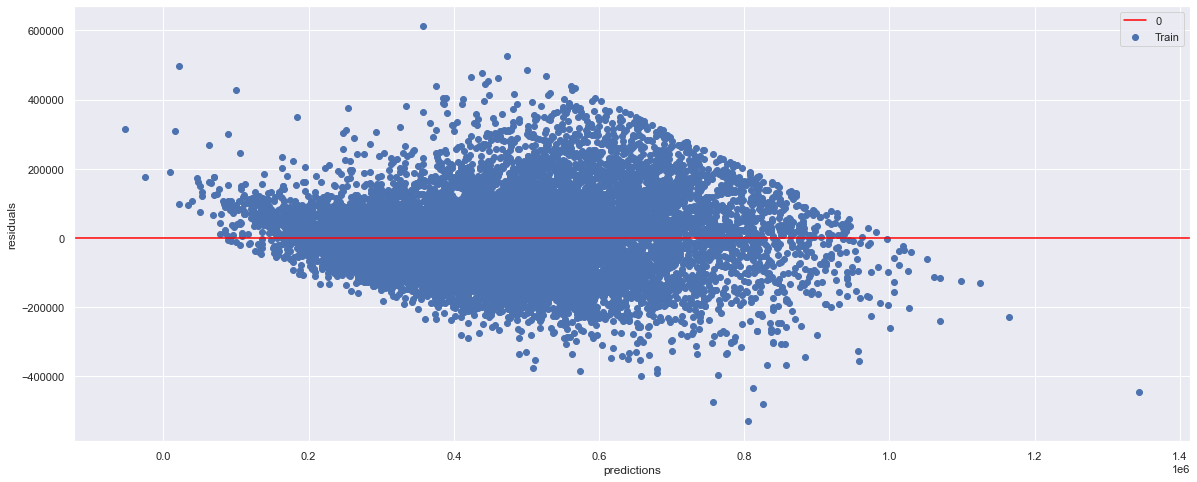

In [27]:
preds1 = all_price.predict(sm.add_constant(X1))    


plt.scatter(preds1, y-preds1, label='Train')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

We can see the actual price is fairly spread out from the prediction, we can see the line still exists.

## Creation of df_que

Using a heatmap, we tried to limit multicolinearity by dropping columns that were 0.7 or higher correlated to other columns. We dropped "grade", "sqft_above", "sqft_living15", "bathrooms", "sqft_lot15", "id" and created df_que.

In [28]:
df_que = df.copy()
#Creates a copy of df to work on

In [29]:
df_que = df_que.drop(columns=[
    "grade", 
    "sqft_above", 
    "sqft_living15", 
    "bathrooms", 
    "sqft_lot15", 
    "id"
])

### Third Model

After doing this, we did another linear regression model. The results of this were a r-squared of 0.620 and p-value of the f statistic of 0.

In [30]:
X2 = df_que.drop(columns=["price"])
y2 = df_que["price"]

all_price1 = sm.OLS(y2, sm.add_constant(X2)).fit()
simple_model_summary = all_price1.summary()
simple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     1798.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:00:30   Log-Likelihood:            -1.8845e+05
No. Observations:               14359   AIC:                         3.769e+05
Df Residuals:                   14345   BIC:                         3.770e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.908e+06   2.14e+06     -1.830      0.067   -8.09e+06    2.78e+05
bedrooms        -1.7e+04   1511.703    -11.242      0.000      -2e+04    -1.4e+04
sqft_living     172.6731      2.154     80.151      0.000     168.450     176.896
sqft_lot          0.1530      0.026      5.915      0.000       0.102       0.204
floors         4.261e+04   2586.544     16.474      0.000    3.75e+04    4.77e+04
waterfront     8.454e+04      2e+04      4.229      0.000    4.54e+04    1.24e+05
view           4.224e+04   1796.040     23.519      0.000    3.87e+04    4.58e+04
condition      2.562e+04   1736.420     14.754      0.000    2.22e+04     2.9e+04
sqft_basement   -35.7596      3.311    -10.802      0.000     -42.249     -29.271
yr_built       -889.1988     49.878    -17.827      0.000    -986.966    -791.431
yr_renovated     19.6409      2.864      6.858      0.000      14.027      25.254
zipcode        -322.4740     24.293    -13.274      0.000    -370.092    -274.856
lat            6.189e+05   7622.878     81.193      0.000    6.04e+05    6.34e+05
long          -6.589e+04   9433.287     -6.985      0.000   -8.44e+04   -4.74e+04
==============================================================================
Omnibus:                      584.784   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.222
Skew:                           0.408   Prob(JB):                    2.58e-177
Kurtosis:                       3.832   Cond. No.                     2.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third Model Prediction Error Graph

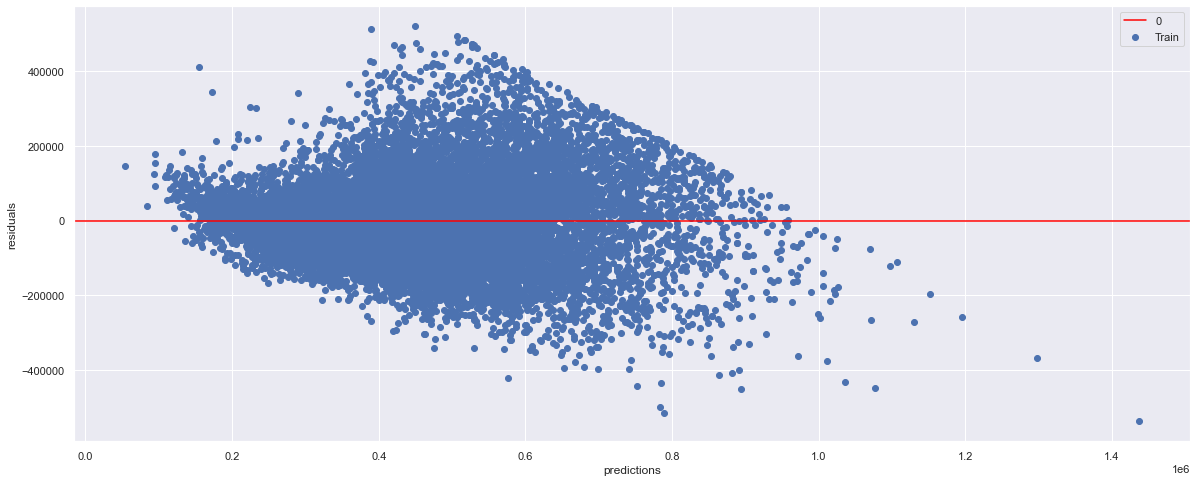

In [31]:
preds2 = all_price1.predict(sm.add_constant(X2))    


plt.scatter(preds2, y-preds2, label='Train')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

We can see the actual price is fairly spread out from the prediction, we can see the line still exists.

### Final Model

When looking at that model we realized that zipcode needed to be changed. It is a number, but repersents a category more than a numberical value. We decided to OneHotEncode the zipcode column. After doing this we did a linear regression model using a train, test split. The results of this model were 
Train R2: 0.8092, Test R2: 0.8008, RMSE: $85718.62.

In [32]:
X3 = df_que.drop(columns=["price"])
y3 = df_que["price"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X3, y3, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [33]:
zip_train = X_train1[["zipcode"]]
zip_test = X_test1[["zipcode"]]
ohe = OneHotEncoder(handle_unknown='ignore',
                        sparse=False,
                        categories='auto')

ohe.fit(zip_train)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [34]:
zip_encoded_train = ohe.transform(zip_train)
zip_encoded_test = ohe.transform(zip_test)

In [35]:
zip_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    zip_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_train1.index
)

zip_encoded_test = pd.DataFrame(
    # Pass in NumPy array
    zip_encoded_test,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=X_test1.index
)

Drop zipcode column and concat the OHE pandas Dataframe

In [36]:
X_train1.drop("zipcode", axis=1, inplace=True)

X_train1 = pd.concat([X_train1, zip_encoded_train], axis=1)


X_test1.drop("zipcode", axis=1, inplace=True)

X_test1 = pd.concat([X_test1, zip_encoded_test], axis=1)

In [37]:
lr_x1 = LinearRegression()

lr_x1.fit(X_train1, y_train1)

print(f"Train R2: {lr_x1.score(X_train1, y_train1):.4f}")
print(f"Test R2: {lr_x1.score(X_test1, y_test1):.4f}")
y_pred1 = lr_x1.predict(X_test1)
print(f"RMSE: ${mae(y_test1, y_pred1, squared = False)}")

Train R2: 0.8092
Test R2: 0.8008
RMSE: $85718.61618795569


### Final Model Prediction Error Graph

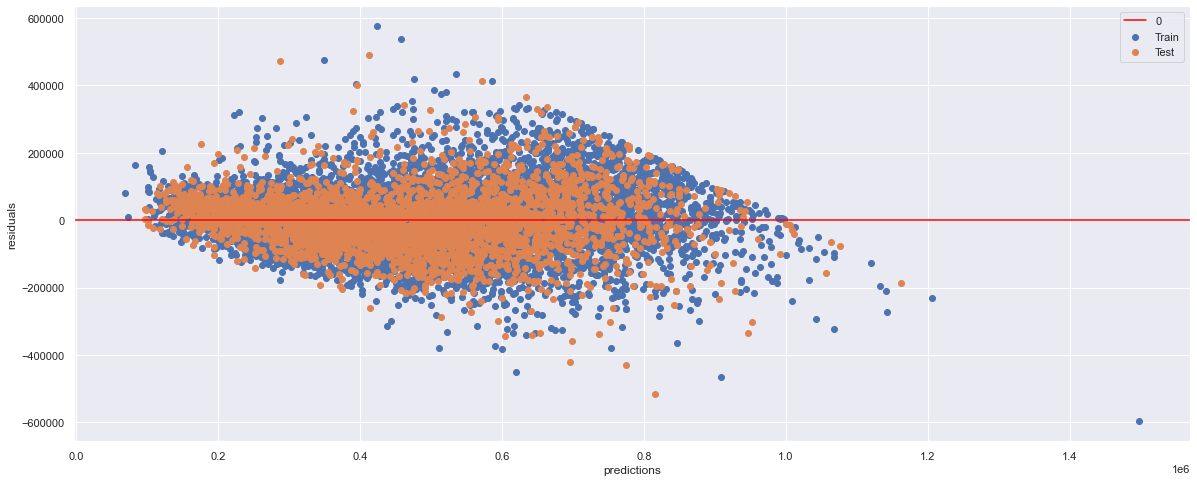

In [38]:
train_preds = lr_x1.predict(X_train1)    
test_preds = lr_x1.predict(X_test1)

plt.scatter(train_preds, y_train1-train_preds, label='Train')
plt.scatter(test_preds, y_test1-test_preds, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

We can see that the graph is fairly dense towards the center prediction line however there is some variance and an odd line were predictions do not cross.

# Creation of the House Price Predictor
Using the final model we created our House Price Predictor

### House Price Predictor

In [39]:
def predictor(
    base_df,
    bedrooms=float(0),
    sqft_living=float(0),
    sqft_lot=float(0),
    floors=float(0),
    waterfront=float(0),
    view=float(0),
    condition=float(0),
    sqft_basement=float(0),
    yr_built=float(0),
    yr_renovated=float(0),
    zipcode=float(0),
    lat=float(0),
    long=float(0)
):
    #all our inputs, from a base df to every housing statistic for a given house
    pred_df = pd.DataFrame({
        'bedrooms': [bedrooms],
        'sqft_living': [sqft_living],
        'sqft_lot': [sqft_lot],
        'floors': [floors],
        'waterfront': [waterfront],
        'view': [view],
        'condition': [condition],
        'sqft_basement': [sqft_basement],
        'yr_built': [yr_built],
        'yr_renovated': [yr_renovated],
        'zipcode': [zipcode],
        'lat': [lat],
        'long':[long]
    })
    # creates the pandas dataframe
    
    X = base_df.drop(columns=["price"])
    y = base_df["price"]
    #sets our X, y
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)
    #Train test split for base df
    
    zip_train = X_train[["zipcode"]]
    zip_test = X_test[["zipcode"]]
    zip_pred = pred_df[["zipcode"]]
    ohe = OneHotEncoder(handle_unknown='ignore',
                        sparse=False,
                        categories='auto')
    ohe.fit(zip_train)
    
    zip_encoded_train = ohe.transform(zip_train)
    zip_encoded_test = ohe.transform(zip_test)
    zip_encoded_pred = ohe.transform(zip_pred)
    #OneHotEncoder for the zipcode
    
    zip_encoded_train = pd.DataFrame(
    # Pass in NumPy array
        zip_encoded_train,
    # Set the column names to the categories found by OHE
        columns=ohe.categories_[0],
    # Set the index to match X_train's index
        index=X_train.index
    )

    zip_encoded_test = pd.DataFrame(
    # Pass in NumPy array
        zip_encoded_test,
    # Set the column names to the categories found by OHE
        columns=ohe.categories_[0],
    # Set the index to match X_train's index
        index=X_test.index
    )
    
    zip_encoded_pred = pd.DataFrame(
    # Pass in NumPy array
        zip_encoded_pred,
    # Set the column names to the categories found by OHE
        columns=ohe.categories_[0],
    # Set the index to match X_train's index
        index=pred_df.index
    )
    #creates dataframe for OneHotEncoder Columns
    
    X_train.drop("zipcode", axis=1, inplace=True)

    X_train = pd.concat([X_train, zip_encoded_train], axis=1)


    X_test.drop("zipcode", axis=1, inplace=True)

    X_test = pd.concat([X_test, zip_encoded_test], axis=1)
    
    
    pred_df.drop("zipcode", axis=1, inplace=True)

    pred_df = pd.concat([pred_df, zip_encoded_pred], axis=1)
    #Concats the OHE Columns and df while dropping zip
    
    lr_x = LinearRegression()

    lr_x.fit(X_train, y_train)
    #Our linear model
    
    print(f"Train R2: {lr_x.score(X_train, y_train):.4f}")
    print(f"Test R2: {lr_x.score(X_test, y_test):.4f}")
    #we have a train and test split so we can see the R2 value for a given base df
    y_pred = lr_x.predict(X_test)
    print(f"RMSE: ${mae(y_test, y_pred, squared = False)}")
    #prints RMSE
    
    pred = lr_x.predict(sm.add_constant(pred_df))
    print("Predicted Prices:")
    for x in pred:
        print("$", f"{x}")
    #prints predicted house price

### Using the House Price Predictor

In [40]:
predictor(
    base_df=df_que, 
    bedrooms=2, 
    sqft_living=975, 
    sqft_lot=1021, 
    floors=1, 
    waterfront=1, 
    condition=2, 
    view=0,
    sqft_basement=0, 
    yr_built=1961, 
    lat=47.638310, 
    long=-122.276350, 
    zipcode=98112
)

Train R2: 0.8092
Test R2: 0.8008
RMSE: $85718.61618795569
Predicted Prices:
$ 823645.1045603901


Our model predicted the house is worth 823645.10 dollars the [house](https://www.zillow.com/homedetails/2040-43rd-Ave-E-APT-201-Seattle-WA-98112/48925029_zpid/?) was priced at 470.4k dollars and was then flipped for 837.5k dollars.

Thus we could see that if someone had used our model they could have bought that house then latter flipped it for 400k dollars profit.

## Exploring Features to Raise Value of the House
Next we wanted to explore recommendations for things to do to the house, after buying the house, to increase its price. We found two recommendations for increase a house's price. We go into depth about these two below.

## Increasing the condition of the house
First recommendation we have is if you buy a house that its condition is below average. Then getting the house condition to just average increase the value of the house by a significant amount. This is shown by the graph below. Also recommend that if the house is already average or above average, then there is no real need to increase the conidtion of the house because it does not seem to raise the price of the house by much, if any at all. We also do understand that increasing the condition of the house costs money, and so this would be up to our client to determine if the cost to raise the condition of the house is worht the price increase of the house.

![House image](./Cooper/Condition_vs_Price.png)

## Increasing the square feet of the living space
The next recommendation we have for our client is to increase the Square feet of the living space as this has a strong positive relationship with price. This is seen in the graph below. Once again we also do understand that increasing the sqaure feet of the house costs money, and so this would be up to our client to determine if the cost is worth the value increase.
![House image](./Cooper/SQFT_Living_vs_Price.png)

## Conclusion
We have 3 recommendations for our client.
- Use our House Price predictor to find houses that are being listed lower than what they should be worth.
- After buying the house, look into ways to improve the condition of the house if the house is below average. If the house is average, or above average, then no need to increase condition of house. 
- After buying the house, look into ways to increase the square feet of the living space of the house. 

## Future Work
- Investigate if the cost of increasing the condition to the would be worth the value increase of the house. Also doing the same thing to see if the cost of adding living space would be worth the value increase.
- Another next step would be to gather more relevant data recent data and make another model for more current homes.


## For More Information

- [Data](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)
- [Slide Show](https://github.com/Co-nn/Analyzing-House-Sales-in-King-County-Washington/blob/main/Connor%20and%20Cooper.pdf)
- [Zillow house](https://www.zillow.com/homedetails/2040-43rd-Ave-E-APT-201-Seattle-WA-98112/48925029_zpid/)